In [1]:
import tweepy
import pandas as pd
import re
from wordcloud import WordCloud

from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/luis/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
consumer_key = 'IWWFwOdb3FdXynSwJCfZQXfSL'
consumer_secret = 'fXstMlAbB7GWqlmNOauZ7a2fqFbaWTzQyPphP0cqQ4Tu9Oh3X7'
access_token = '2389240944-t51ayAWJZTzwCFFsmXJUislFPSbJyjkQeHx4Wt2'
access_token_secret = 'bDMpw7SdloDD9DZnzUsFKHVSCNmhuPEtdNjpK05wTdmSf'

In [4]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

In [5]:
def clean_tweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\s+)", " ", tweet).split())

In [6]:
api = tweepy.API(auth)
tweets = api.search('Captain Marvel', count=200)

data = pd.DataFrame(data=[clean_tweet(tweet.text) for tweet in tweets], columns=['tweets'])

In [7]:
data['tweets'].head(3)

0    RT I m pretty mad right now that the protagoni...
1    If you don t like Captain Marvel you are entit...
2                   I can t wait to see Captain Marvel
Name: tweets, dtype: object

In [8]:
i = 10
print(tweets[i].id)
print(tweets[i].created_at)
print(tweets[i].source)
print(tweets[i].text)
print(tweets[i].geo)

1103706287924076544
2019-03-07 17:17:39
Twitter for iPhone
RT @greenIight: “i’m not watching captain marvel cause brie larson is sexist and racist towards white men” https://t.co/nzV1h3NOd5
None


In [9]:
data['tidy_tweet'] = data['tweets'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
data['tidy_tweet'] = data['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if w.isalpha()]))
tokenized_tweet = data['tidy_tweet'].apply(lambda x : x.lower().split())

In [10]:
data.head(3)

,tweets,tidy_tweet
0,RT I m pretty mad right now that the protagoni...,pretty right that protagonist Captain Marvel u...
1,If you don t like Captain Marvel you are entit...,like Captain Marvel entitled your opinion also...
2,I can t wait to see Captain Marvel,wait Captain Marvel


In [11]:
print(data['tweets'][0])
print(data['tidy_tweet'][0])

RT I m pretty mad right now that the protagonist in Captain Marvel is unrealistically strong for a woman unlike all the o
pretty right that protagonist Captain Marvel unrealistically strong woman unlike


In [12]:
porter = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [porter.stem(i) for i in x])

In [13]:
tokenized_tweet[0]

['pretti',
 'right',
 'that',
 'protagonist',
 'captain',
 'marvel',
 'unrealist',
 'strong',
 'woman',
 'unlik']

In [14]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

In [15]:
data['tidy_tweet'] = tokenized_tweet

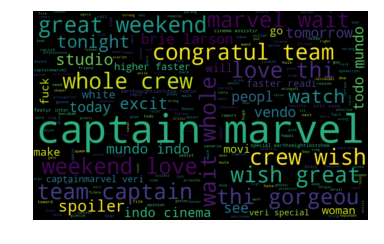

In [16]:
all_words = ' '.join([text for text in data['tidy_tweet']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.axis('off')
plt.imshow(wordcloud, interpolation="bilinear")

In [17]:
del(data['tweets'])

In [18]:
sid = SentimentIntensityAnalyzer()

In [19]:
listy = []

for index, row in data.iterrows():
    sentiment = sid.polarity_scores(row["tidy_tweet"])
    listy.append([sentiment['neg'], sentiment['neu'], sentiment['pos'], sentiment['compound']])

In [20]:
data[['neg', 'pos', 'neu', 'compound']] = pd.DataFrame(listy)

In [21]:
data['Negative'] = data['compound'] < -0.1
data['Positive'] = data['compound'] > 0.1

data.iloc[:]['compound'] > 0.1

positive_words = ' '.join([text for text in data['tidy_tweet'][data.iloc[:]['compound'] > 0.1]])
negative_words = ' '.join([text for text in data['tidy_tweet'][data.iloc[:]['compound'] < 0.1]])

In [22]:
def word_count(str):
    counts = {}
    words = str.split()
    for word in words:
        if word in counts:
            counts[word] = counts[word] + 1
        else:
            counts[word] = 1
    return counts

In [23]:
negative_dict = word_count(negative_words)
del(negative_dict['http'])

In [24]:
d = {'Word': list(negative_dict.keys()),'Word_Count': list(negative_dict.values())}
df = pd.DataFrame(data=d)

Text(0.5, 1.0, 'Harsh words vs Count')

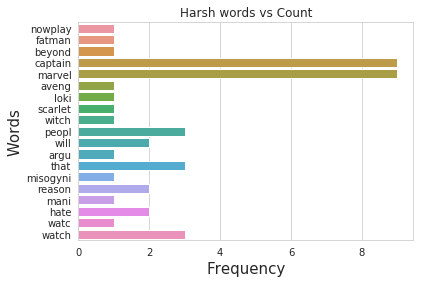

In [25]:
sns.barplot(data=df.head(19), x= "Word_Count", y = "Word")
plt.ylabel("Words", fontsize=15)
plt.xlabel("Frequency", fontsize=15)
plt.title("Harsh words vs Count")

In [26]:
bow_vector = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vector.fit_transform(data['tidy_tweet'])

In [27]:
tfidf_vector = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vector.fit_transform(data['tidy_tweet'])

In [32]:
data.drop(['Positive', 'Negative'],axis = 1).head()

,tidy_tweet,neg,pos,neu,compound
0,pretti right that protagonist captain marvel u...,0.000,0.567,0.433,0.7269
1,like captain marvel entitl your opinion also w...,0.231,0.373,0.396,0.2960
2,wait captain marvel,0.000,0.417,0.583,0.4215
3,doe captain marvel have relat with wasp,0.000,0.682,0.318,0.4215
4,wish collect understand that want captain marv...,0.000,0.595,0.405,0.7003


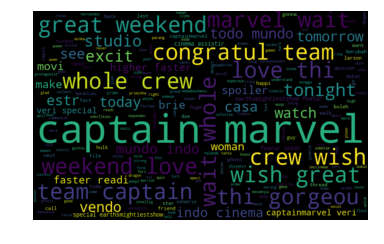

In [28]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(positive_words)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()